###Step 1

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
!cp -r /content/drive/MyDrive/Sen2Fire /content/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# DATA_DIR = "/content/drive/MyDrive/Sen2Fire"

# if not os.path.exists(DATA_DIR):
#     os.makedirs(DATA_DIR)

# !wget -O "$DATA_DIR/Sen2Fire.zip" https://zenodo.org/records/10881058/files/Sen2Fire.zip

# !unzip -q "$DATA_DIR/Sen2Fire.zip" -d "$DATA_DIR"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-12-17 09:35:47--  https://zenodo.org/records/10881058/files/Sen2Fire.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6346737700 (5.9G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Sen2Fire/Sen2Fire.zip’

/content/drive/MyDr 100%[===================>]   5.91G  2.35MB/s    in 51m 51s 

2025-12-17 10:27:39 (1.95 MB/s) - ‘/content/drive/MyDrive/Sen2Fire/Sen2Fire.zip’ saved [6346737700/6346737700]



In [ ]:
sample = np.load('Sen2Fire/scene1/scene_1_patch_1_1.npz')
images = sample['image'].shape
labels = sample['label'].shape
aerosol = sample['aerosol'].shape
print(images, labels, aerosol)

(12, 512, 512) (512, 512) (512, 512)


#####Scene Split

In [ ]:
TRAIN_SCENES = ["Sen2Fire/scene1", "Sen2Fire/scene2"]
VAL_SCENES   = ["Sen2Fire/scene3"]
TEST_SCENES  = ["Sen2Fire/scene4"]


def collect_files(scenes):
    files = []
    for s in scenes:
        for f in os.listdir(s):
            if f.endswith(".npz"):
                files.append(os.path.join(s, f))
    return sorted(files)

train_files = collect_files(TRAIN_SCENES)
val_files   = collect_files(VAL_SCENES)
test_files  = collect_files(TEST_SCENES)

print(len(train_files), len(val_files), len(test_files))


1458 504 504


#####Visual Inspection

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

# RGB Composite (B4, B3, B2)
def get_rgb(img):
    rgb = np.stack([img[3], img[2], img[1]], axis=-1)
    return normalize(rgb)

# SWIR Composite (B12, B8, B4)
def get_swir(img):
    swir = np.stack([img[11], img[7], img[3]], axis=-1)
    return normalize(swir)

# NBR Map (Baseline Feature)
def compute_nbr(nir, swir):
    return (nir - swir) / (nir + swir + 1e-6)
for j in range(270, 1000, 27):
    for i in range(j-27, j):
        sample = np.load(train_files[i])

        fire_mask = sample["label"]
        if fire_mask.mean() > 0.4:
            rgb_img = get_rgb(sample["image"])
            swir_img = get_swir(sample["image"])
            nbr = compute_nbr(sample["image"][7], sample["image"][11])

            # 1x4 grid for each sample
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            axes[0].imshow(rgb_img)
            axes[0].set_title("RGB Image")
            axes[0].axis("off")

            axes[1].imshow(swir_img)
            axes[1].set_title("SWIR Image")
            axes[1].axis("off")

            im = axes[2].imshow(nbr, cmap="RdYlGn")
            axes[2].set_title("NBR Map")
            axes[2].axis("off")
            fig.colorbar(im, ax=axes[2])

            axes[3].imshow(fire_mask, cmap="Reds")
            axes[3].set_title("Fire Mask")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

            print("Fire pixel ratio:", fire_mask.mean())

#####Class Imbalance check

Fire patches: 33
Non-fire patches: 471
percent: 0.06547619047619048


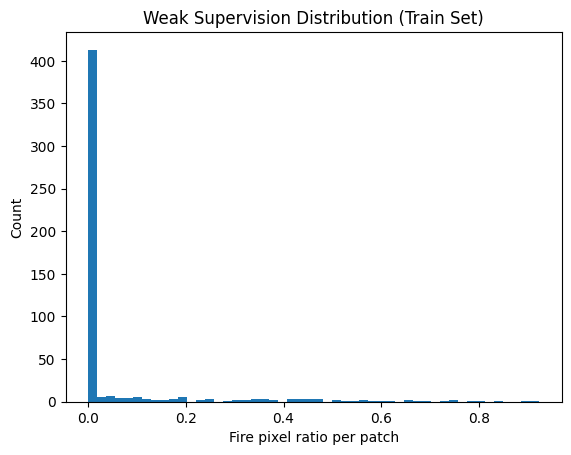

In [ ]:
fire_ratios = []

for f in test_files:
    data = np.load(f)
    fire_ratios.append(data["label"].mean())

fire_ratios = np.array(fire_ratios)

# fire_ratios > 0.4 was considered by author
threshold = 0.4
print("Fire patches:", (fire_ratios > threshold).sum())
print("Non-fire patches:", (fire_ratios <= threshold).sum())
print('percent:', ((fire_ratios > threshold).sum())/((fire_ratios > threshold).sum()+(fire_ratios <= threshold).sum()))

plt.hist(fire_ratios, bins=50)
plt.xlabel("Fire pixel ratio per patch")
plt.ylabel("Count")
plt.title("Weak Supervision Distribution (Train Set)")
plt.show()


###Step 2

####2.1 PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class Sen2FireDataset(Dataset):
    def __init__(self, files, band_idx=None, use_aerosol=False):
        self.files = files
        self.band_idx = band_idx
        self.use_aerosol = use_aerosol

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        img = data["image"]     # (12, 512, 512)
        y = patch_label(data["label"])   # (512, 512)

        if self.band_idx is not None:
            img = img[self.band_idx]

        if self.use_aerosol:
            aerosol = data["aerosol"][None, :, :] # The add creates a dimension for the channel
            img = np.concatenate([img, aerosol], axis=0)  # Concate is used instead of stack as no new dimension is formed

        return torch.tensor(img, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

####2.2 Data Loader

In [ ]:
from torch.utils.data import DataLoader

train_ds = Sen2FireDataset(train_files)
test_ds = Sen2FireDataset(test_files)
val_ds = Sen2FireDataset(val_files)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)
val_loader = DataLoader(val_ds, batch_size=8)

####2.3 Class Weights

In [ ]:
# Determines the class weight for loss function (due to class imbalance)
# We use weighted log Loss function here

def compute_class_weight(files):
    fire = 0
    for f in files:
        fire += (np.load(f)['label'].sum() > 0)
    non_fire = len(files) - fire
    return non_fire/max(fire, 1)

# Weight is required because False Negative classes are not acceptable, and for negative class not required
pos_weight = torch.tensor([compute_class_weight(train_files)])

####2.4 CNN Model

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=12):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

####2.5 Training Loop

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

def train_epoch(loader):
    model.train()
    total_loss = 0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(loader)

####Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def evaluate(loader):
    model.eval()
    all_y = []
    all_probs = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu())
            all_y.append(y.cpu())

    ys = torch.cat(all_y).numpy()          # shape (N,)
    probs = torch.cat(all_probs).numpy()   # shape (N,)
    preds = probs > 0.5

    return {
        "precision": precision_score(ys, preds),
        "recall": recall_score(ys, preds),
        "auroc": roc_auc_score(ys, probs)
    }

####Run Training

In [ ]:
import tqdm
for epoch in tqdm.tqdm(range(5)):
    loss = train_epoch(train_loader)
    val_metrics = evaluate(val_loader)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, val = {val_metrics}")

 20%|██        | 1/5 [02:02<08:08, 122.10s/it]

Epoch 0: Loss = 3.8442, val = {'precision': 0.32, 'recall': 0.851063829787234, 'auroc': np.float64(0.7969252724442137)}


 40%|████      | 2/5 [03:53<05:47, 115.93s/it]

Epoch 1: Loss = 4.0931, val = {'precision': 0.2783171521035599, 'recall': 0.9148936170212766, 'auroc': np.float64(0.7851842241826673)}


 60%|██████    | 3/5 [05:43<03:46, 113.17s/it]

Epoch 2: Loss = 2.9519, val = {'precision': 0.22195704057279236, 'recall': 0.9893617021276596, 'auroc': np.float64(0.8104955889984432)}


 80%|████████  | 4/5 [07:41<01:55, 115.13s/it]

Epoch 3: Loss = 2.6882, val = {'precision': 0.32669322709163345, 'recall': 0.8723404255319149, 'auroc': np.float64(0.8288271925272445)}


100%|██████████| 5/5 [09:32<00:00, 114.54s/it]

Epoch 4: Loss = 1.6352, val = {'precision': 0.341991341991342, 'recall': 0.8404255319148937, 'auroc': np.float64(0.8204462895692788)}


In [ ]:
# PATH = ""
# torch.save(model.state_dict(), PATH)

###3.Error & Disagreement Analysis

####3.1 Prepare Predictions(CNN)

In [ ]:
PATH = '/content/drive/MyDrive/Sen2Fire/cnn_model_weights.pth' # Replace with your file path
device = 'cuda' if torch.cuda.is_available() else "cpu"
model = SimpleCNN()
model.load_state_dict(torch.load(PATH))
model.to(device) # <--- Added this line to move the model to the GPU

def get_predictions(loader):
    model.eval()
    all_probs = []
    all_labels = []
    all_files = []

    # track dataset index manually
    idx = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)                 # shape (B,)
            probs = torch.sigmoid(logits)     # shape (B,)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_size = x.size(0)
            # Correctly collect file paths using the batch index
            all_files.extend(loader.dataset.files[idx : idx + batch_size])
            idx += batch_size

    return (
        np.array(all_probs),
        np.array(all_labels),
        all_files
    )
cnn_probs, y_true, files = get_predictions(val_loader)

####3.2 NBR Baseline Prediction

In [ ]:
def nbr_patch_score(file):
    data = np.load(file)
    img = data["image"]

    nir = img[7]   # B8
    swir = img[11] # B12

    nbr = (nir - swir) / (nir + swir + 1e-6)
    return -nbr.mean()  # higher = more fire-like

nbr_scores = np.array([nbr_patch_score(f) for f in files])

# Normalizing for comparison
nbr_scores = (nbr_scores - nbr_scores.min()) / (nbr_scores.max() - nbr_scores.min())

####3.3 Disagreement Categories (Key Insight part)

In [ ]:
cnn_pred = cnn_probs > 0.5
nbr_pred = nbr_scores > 0.5

groups = {
    "CNN ✔ / NBR ✘": np.where((cnn_pred == 1) & (nbr_pred == 0))[0],
    "CNN ✘ / NBR ✔": np.where((cnn_pred == 0) & (nbr_pred == 1))[0],
    "Both ✔": np.where((cnn_pred == 1) & (nbr_pred == 1))[0],
    "Both ✘": np.where((cnn_pred == 0) & (nbr_pred == 0))[0],
}


####3.4 Visualizing Disagreement

In [ ]:
def visualize_patch(file):
    data = np.load(file)
    img = data["image"]
    lbl = data["label"]

    rgb = np.stack([img[3], img[2], img[1]], axis=-1)
    swir = np.stack([img[11], img[7], img[3]], axis=-1)
    nbr = (img[7] - img[11]) / (img[7] + img[11] + 1e-6)

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow((rgb - rgb.min()) / (rgb.max() - rgb.min()))
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow((swir - swir.min()) / (swir.max() - swir.min()))
    plt.title("SWIR")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(nbr, cmap="RdYlGn")
    plt.title("NBR")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(lbl, cmap="Reds")
    plt.title("MODIS Label")
    plt.axis("off")

    plt.show()

####CNN ✘ / NBR ✔

In [ ]:
for idx in groups["CNN ✘ / NBR ✔"][:5]:
    visualize_patch(files[idx])


####CNN ✔ / NBR ✘

In [ ]:
for idx in groups["CNN ✔ / NBR ✘"][:5]:
    visualize_patch(files[idx])


####False Negative by CNN

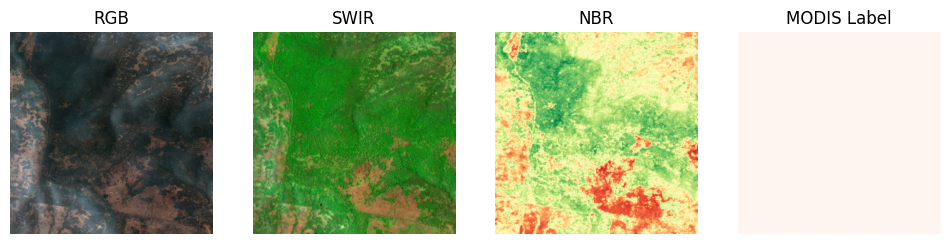

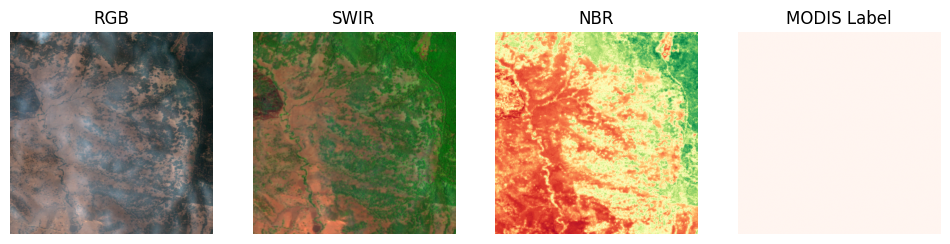

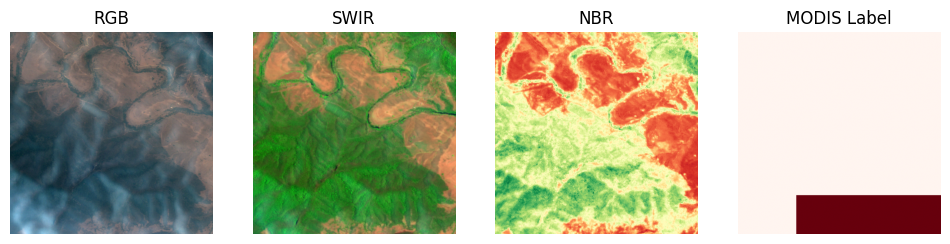

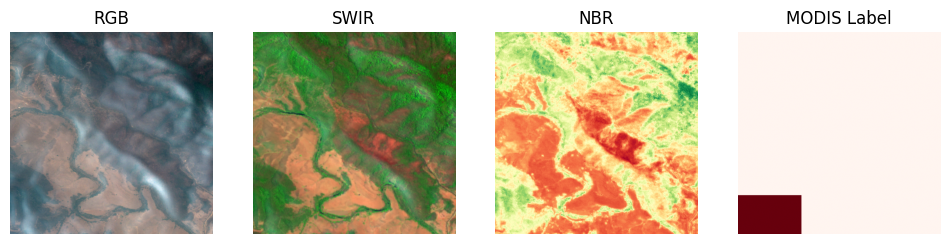

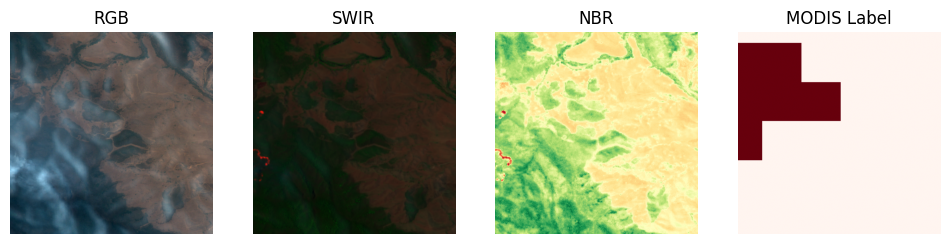

In [ ]:
fn_idx = np.where((cnn_pred == 0) & (y_true == 1))[0]

for idx in fn_idx[:5]:
    visualize_patch(files[idx])


###4. Ablation

####4.1 Albation 1 (Does spatial context Matters?)

In [ ]:
from sklearn.linear_model import LogisticRegression

def patch_label(mask):
    return int(mask.sum() > 0)

def compute_metrics(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob > thresh).astype(int)
    return {
        "auroc": roc_auc_score(y_true, y_prob),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

## Extracting Spectral features
def spectral_features(files, band_idx=None, use_aerosol=False):
    X, y = [], []

    for f in files:
        data = np.load(f)
        img = data["image"]  # (12, H, W)

        if band_idx is not None:
            img = img[band_idx]

        feat = img.mean(axis=(1,2))  # spatially averaged

        if use_aerosol:
            aerosol = data["aerosol"].mean()
            feat = np.concatenate([feat, [aerosol]])

        X.append(feat)
        y.append(patch_label(data["label"]))

    return np.array(X), np.array(y)

## Training Logistic Regression (Spectral Only)
X_tr, y_tr = spectral_features(train_files)
X_va, y_va = spectral_features(val_files)

spec_clf = LogisticRegression(
    class_weight="balanced",
    max_iter=2000
)
spec_clf.fit(X_tr, y_tr)

val_probs = spec_clf.predict_proba(X_va)[:,1]
spec_metrics = compute_metrics(y_va, val_probs)

print("Ablation 1 — Spectral-only:", spec_metrics)


Ablation 1 — Spectral-only: {'auroc': np.float64(0.73858329008822), 'precision': 0.3821656050955414, 'recall': 0.6382978723404256}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


####Albation 2 (which bands matters?)

In [ ]:
## Band Configuration
BAND_SETS = {
    "RGB": [1,2,3],          # B2, B3, B4
    "NIR_SWIR": [7,10,11],   # B8, B11, B12
    "ALL": list(range(12)),
}

## Train + Evaluate Function
def train_and_eval_cnn(train_files, val_files, band_idx, use_aerosol=False, epochs=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_ds = Sen2FireDataset(train_files, band_idx, use_aerosol)
    val_ds   = Sen2FireDataset(val_files, band_idx, use_aerosol)

    train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_dl   = DataLoader(val_ds, batch_size=8)

    # class weight
    fire = sum(patch_label(np.load(f)["label"]) for f in train_files)
    non_fire = len(train_files) - fire
    pos_weight = torch.tensor([non_fire / fire]).to(device)

    model = SimpleCNN(
        in_channels=len(band_idx) + (1 if use_aerosol else 0)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # train
    for _ in range(epochs):
        model.train()
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()

    # eval
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for x, y in val_dl:
            p = torch.sigmoid(model(x.to(device))).cpu().numpy()
            probs.extend(p)
            labels.extend(y.numpy())

    return compute_metrics(np.array(labels), np.array(probs))

## Running Band Albation
band_results = {}

for name, idx in BAND_SETS.items():
    metrics = train_and_eval_cnn(train_files, val_files, idx)
    band_results[name] = metrics
    print(f"Ablation 2 — {name}:", metrics)


Ablation 2 — RGB: {'auroc': np.float64(0.6961338868707836), 'precision': 0.22015915119363394, 'recall': 0.8829787234042553}
Ablation 2 — NIR_SWIR: {'auroc': np.float64(0.8324468085106383), 'precision': 0.27, 'recall': 0.8617021276595744}
Ablation 2 — ALL: {'auroc': np.float64(0.7823300467047224), 'precision': 0.27009646302250806, 'recall': 0.8936170212765957}


####Albation 3 (Adding Aerosol helps?)

In [ ]:
aerosol_metrics = train_and_eval_cnn(
    train_files,
    val_files,
    BAND_SETS["ALL"],
    use_aerosol=True
)

print("Ablation 3 — ALL + Aerosol:", aerosol_metrics)

Ablation 3 — ALL + Aerosol: {'auroc': np.float64(0.7645822522055007), 'precision': 0.2521246458923513, 'recall': 0.9468085106382979}
